In [50]:
import os
os.environ['R_HOME'] = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
from rpy2.rinterface_lib import openrlib
openrlib.R_HOME = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
import scanpy as sc
import pandas
import matplotlib.pyplot as plt

In [3]:
%load_ext rpy2.ipython

In [6]:
%%R
library(Matrix)
library(ArchR)
library(ggplot2)
library(dplyr)

In [5]:
%%R
scatac.object <- loadArchRProject('./data/multiome_mouse_4wks_scatac')

R[write to console]: Successfully loaded ArchRProject!

R[write to console]: 
                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___  

In [27]:
%%R
scatac.object <- addCellColData(scatac.object, 
                                paste(scatac.object$celltype_label, scatac.object$Sample, sep='_'), 
                                'sample_celltype_label', 
                                scatac.object$cellNames, force=TRUE)

R[write to console]: Overriding previous entry for sample_celltype_label



In [28]:
%%R
addArchRThreads(1)
markersMM <- getMarkerFeatures(
    ArchRProj = scatac.object[scatac.object$celltype_label %in% c("IL10+ Treg", "IL10- Treg", "PD1+ Th1"),],
    useMatrix = "MotifMatrix",
    groupBy = "sample_celltype_label",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    useSeqnames="deviations", # "z"
    testMethod = "wilcoxon")

R[write to console]: Setting default number of Parallel threads to 1.



R[write to console]: Identified 43 markers!



 [1] "AC0384|FOXO/FOXJ|Forkhead"         "AC0015|RUNX|Runt"                 
 [3] "AC0143|RBPJ|CSL"                   "AC0437|CEBPA|bZIP"                
 [5] "AC0610|TCF/ASCL|bHLH"              "AC0254|GATA/TRPS|GATA"            
 [7] "AC0408|RORC/RORA|Nuclear_receptor" "AC0039|TFAP2A/TFAP2C|AP-2"        
 [9] "AC0064|RFX/MXI|RFX"                "AC0072|MYBL|Myb/SANT"             
[11] "AC0081|NFIA/NFIC|SMAD"             "AC0097|DNMT/PHF|CxxC"             
[13] "AC0123|FOXO|Forkhead"              "AC0158|E2F/TFDP|E2F"              
[15] "AC0161|E2F/ZBTB|E2F"               "AC0257|FOXG/FOXK|Forkhead"        
[17] "AC0410|RARA/RARG|Nuclear_receptor" "AC0430|TCF7L/LEF|Sox"             
[19] "AC0434|NR2F/RXRG|Nuclear_receptor" "AC0212|STAT/STAT5A|STAT"          
[21] "AC0196|NFKB/RELA|Rel"              "AC0392|CENPBD/GMEB|CxxC"          
[23] "AC0424|NR4A|Nuclear_receptor"      "AC0547|ATF/CREB|bZIP"             
[25] "AC0407|RXRG/RARB|Nuclear_receptor" "AC0244|MAFG/MAFF|bZIP"            

R[write to console]: Adding Annotations..

R[write to console]: Preparing Main Heatmap..

R[write to console]: 'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



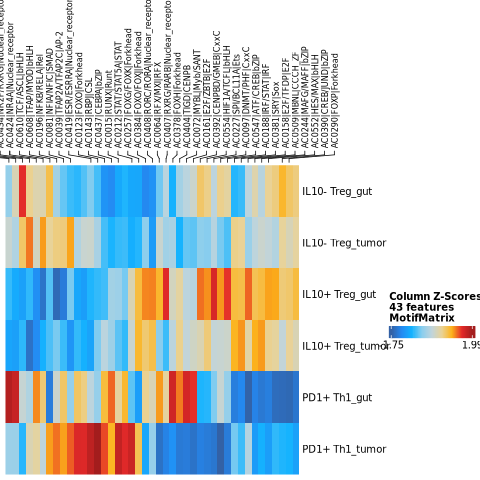

In [29]:
%%R

markersMM_select <- markersMM

rowData(markersMM_select)$name1 <- unlist(lapply(rowData(markersMM_select)$name, function(x) strsplit(x, '\\|')[[1]][2]))
markersMM_select <- markersMM_select[!duplicated(rowData(markersMM_select)$name1), ]
markersMM_select <- markersMM_select[!grepl(
    'CTCF|AC0252|AC0253|C2H2|AC0046|AC0207|AC0414|AC0416|AC0379|AC0155|Unknown|TFCP|ZZZ|AC0455|AC0170|AC0540|AC0631|AC0134|AC0232|AC0421|AC0632|AC0012|AC0071|AC0555|AC0556|AC0038|AC0208|Homeodomain|AC0524|AC0400|AC0264|AC0621|AC0360|AC0385|AC0525|AC0087|AC0545|AC0617|AC0541|AC0387|AC0626', 
                                        rowData(markersMM_select)$name), ]
markersMM_select <- markersMM_select[!(((do.call(pmin, assay(markersMM_select, 'FDR')[, 1:3]) > 1e-4) & 
                                  assay(markersMM_select, 'FDR')[, 4] < 1e-4))]

heatmapMM <- plotMarkerHeatmap(
      seMarker = markersMM_select, 
      cutOff = "FDR <= 1e-3", 
      transpose = TRUE,
      log2Norm = FALSE, returnMatrix=FALSE, clusterCols=FALSE, binaryClusterRows=FALSE
    )
heatmapMM

In [65]:
adata = sc.read_h5ad('./data/multiome_mouse_4wks_scrna.h5ad')
adata_cd4_t = adata[(adata.obs['celltype_label'].isin(['IL10- Treg', 'CD4 RLE', 'Memory CD4',
                            'Th17', 'Th1', 
                            'IL10+ Treg', 'Tfh', 'PD1+ Th1',
                            'Th2'])) & (adata.obs['batch']=='Tumor')].raw.to_adata() 
adata_cd4_t.obs['batch_celltype'] = [r['batch'] + '_' + r['celltype_label'] for i,r in adata_cd4_t.obs.iterrows()]
sc.pp.filter_genes(adata_cd4_t, min_cells=10)
adata_cd4_t

AnnData object with n_obs × n_vars = 3063 × 12029
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 's_score', 'g2m_score', 'Leiden_clusters', 'celltype', 'ATAC_clusters', 'old_celltype', 'leiden', 'clusters_new', 'celltype_new', 'celltype_numbered', 'clusters_tTreg', 'celltype_numbered_new_1', 'celltype_numbered_new_2', 'celltype_label', 'batch_celltype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_clusters_colors', 'Leiden_clusters_colors', 'batch_colors', 'celltype_colors', 'celltype_label_colors', 'celltype_new_colors', 'celltype_numbered_colors', 'celltype_n

In [67]:
tcr_dep_genes = pandas.read_csv("./data/agl_up.txt", sep=' ')
tcr_dep_genes = tcr_dep_genes[tcr_dep_genes['SYMBOL'].isin(adata_cd4_t.var_names)][:30]

sc.tl.score_genes(adata_cd4_t, tcr_dep_genes['SYMBOL'].values.tolist(), score_name='tcr_genes_score', n_bins=10)

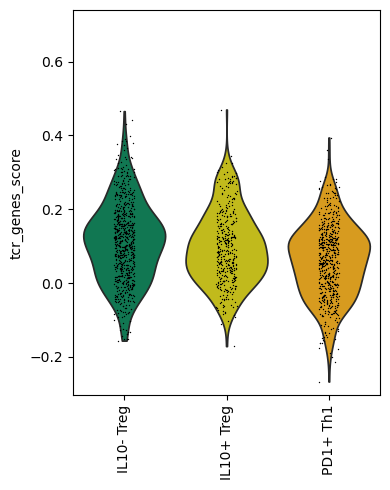

In [75]:
plt.figure(figsize=(4, 5))
adata_cd4_sub = adata_cd4_t[(adata_cd4_t.obs['celltype_label'].isin(['IL10- Treg', 'IL10+ Treg',
                                                'PD1+ Th1'])) & (adata_cd4_t.obs['batch']=='Tumor')].copy()
ax = sc.pl.violin(adata_cd4_sub, 'tcr_genes_score', groupby='celltype_label', 
                 rotation=90, show=False, ax=plt.gca(), order=['IL10- Treg', 'IL10+ Treg', 'PD1+ Th1']) # palette=celltype_colors, 
ax.set_ylim((ax.get_ylim()[0], 0.74))
plt.tight_layout()
plt.show()

In [76]:
adata_tcr = sc.read_h5ad('./data/mouse_2_4_6wks_scrna.h5ad')

{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

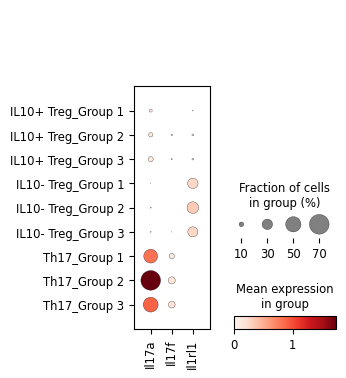

In [80]:
sc.pl.dotplot(adata_tcr[(adata_tcr.obs['celltype_label'].isin(['IL10+ Treg', 'IL10- Treg', 'Th17'])) & (adata_tcr.obs['batch']=='Tumor')], 
              ['Il17a', 'Il17f', 'Il1rl1'], groupby=['celltype_label', 'timepoint'], show=False)

{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

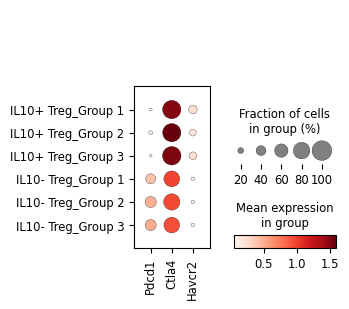

In [81]:
sc.pl.dotplot(adata_tcr[(adata_tcr.obs['celltype_label'].isin(['IL10+ Treg', 'IL10- Treg'])) & (adata_tcr.obs['batch']=='Tumor')], 
              ['Pdcd1', 'Ctla4', 'Havcr2'], groupby=['celltype_label', 'timepoint'], show=False)